# Step 3: Quantile Delta Mapping with reimplemented cmethods tools
Apply reimplemented QDM functionality to additional example cases: longer time series, full grid around Greenland, and sectoral average TF.

23 Jan 2025 | EHU

Edits:
- 23 Jan: Loading in 1950-1999 rather than 2000-2014. Give us a longer series to play with and see how QDM performs
- 24 Jan: Use `rioxarray` to match the EN4 grid to CESM, and then apply our QDM function to the full grid.
- TODO: sectoral averages compared with point series

In [1]:
import os
import sys
import copy
import csv
import time
import datetime
import math
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt

# sys.path.append('/home/theghub/ehultee/ISMIP7-utils/python-cmethods')
from cmethods import adjust

# from verjansFunctions import qmProjCannon2015

## Re-implement functions from Cmethods

In [2]:
## from cmethods.utils
import warnings
from typing import TYPE_CHECKING, Optional, Union, TypeVar

XRData_t = (xr.Dataset, xr.DataArray)
NPData_t = (list, np.ndarray, np.generic)
XRData = TypeVar("XRData", xr.Dataset, xr.DataArray)
NPData = TypeVar("NPData", list, np.ndarray, np.generic)


def check_xr_types(obs: XRData, simh: XRData, simp: XRData) -> None:
    """
    Checks if the parameters are in the correct type. **only used internally**
    """
    phrase: str = "must be type xarray.core.dataarray.Dataset or xarray.core.dataarray.DataArray"

    if not isinstance(obs, XRData_t):
        raise TypeError(f"'obs' {phrase}")
    if not isinstance(simh, XRData_t):
        raise TypeError(f"'simh' {phrase}")
    if not isinstance(simp, XRData_t):
        raise TypeError(f"'simp' {phrase}")

def check_np_types(
    obs: NPData,
    simh: NPData,
    simp: NPData,
) -> None:
    """
    Checks if the parameters are in the correct type. **only used internally**
    """
    phrase: str = "must be type list, np.ndarray or np.generic"

    if not isinstance(obs, NPData_t):
        raise TypeError(f"'obs' {phrase}")
    if not isinstance(simh, NPData_t):
        raise TypeError(f"'simh' {phrase}")
    if not isinstance(simp, NPData_t):
        raise TypeError(f"'simp' {phrase}")

def nan_or_equal(value1: float, value2: float) -> bool:
    """
    Returns True if the values are equal or at least one is NaN

    :param value1: First value to check
    :type value1: float
    :param value2: Second value to check
    :type value2: float
    :return: If any value is NaN or values are equal
    :rtype: bool
    """
    return np.isnan(value1) or np.isnan(value2) or value1 == value2
        
def ensure_dividable(
    numerator: Union[float, np.ndarray],
    denominator: Union[float, np.ndarray],
    max_scaling_factor: float,
) -> np.ndarray:
    """
    Ensures that the arrays can be divided. The numerator will be multiplied by
    the maximum scaling factor of the CMethods class if division by zero.

    :param numerator: Numerator to use
    :type numerator: np.ndarray
    :param denominator: Denominator that can be zero
    :type denominator: np.ndarray
    :return: Zero-ensured division
    :rtype: np.ndarray | float
    """
    with np.errstate(divide="ignore", invalid="ignore"):
        result = numerator / denominator

    if isinstance(numerator, np.ndarray):
        mask_inf = np.isinf(result)
        result[mask_inf] = numerator[mask_inf] * max_scaling_factor  # type: ignore[index]

        mask_nan = np.isnan(result)
        result[mask_nan] = 0  # type: ignore[index]
    elif np.isinf(result):
        result = numerator * max_scaling_factor
    elif np.isnan(result):
        result = 0.0

    return result

def get_pdf(
    x: Union[list, np.ndarray],
    xbins: Union[list, np.ndarray],
) -> np.ndarray:
    r"""
    Compuites and returns the the probability density function :math:`P(x)`
    of ``x`` based on ``xbins``.

    :param x: The vector to get :math:`P(x)` from
    :type x: list | np.ndarray
    :param xbins: The boundaries/bins of :math:`P(x)`
    :type xbins: list | np.ndarray
    :return: The probability densitiy function of ``x``
    :rtype: np.ndarray

    .. code-block:: python
        :linenos:
        :caption: Compute the probability density function :math:`P(x)`

        >>> from cmethods get_pdf

        >>> x = [1, 2, 3, 4, 5, 5, 5, 6, 7, 8, 9, 10]
        >>> xbins = [0, 3, 6, 10]
        >>> print(get_pdf(x=x, xbins=xbins))
        [2, 5, 5]
    """
    pdf, _ = np.histogram(x, xbins)
    return pdf


def get_cdf(
    x: Union[list, np.ndarray],
    xbins: Union[list, np.ndarray],
) -> np.ndarray:
    r"""
    Computes and returns returns the cumulative distribution function :math:`F(x)`
    of ``x`` based on ``xbins``.

    :param x: Vector to get :math:`F(x)` from
    :type x: list | np.ndarray
    :param xbins: The boundaries/bins of :math:`F(x)`
    :type xbins: list | np.ndarray
    :return: The cumulative distribution function of ``x``
    :rtype: np.ndarray


    .. code-block:: python
        :linenos:
        :caption: Compute the cumulative distribution function :math:`F(x)`

        >>> from cmethods.utils import get_cdf

        >>> x = [1, 2, 3, 4, 5, 5, 5, 6, 7, 8, 9, 10]
        >>> xbins = [0, 3, 6, 10]
        >>> print(get_cdf(x=x, xbins=xbins))
        [0.0, 0.16666667, 0.58333333, 1.]
    """
    pdf, _ = np.histogram(x, xbins)
    cdf = np.insert(np.cumsum(pdf), 0, 0.0)
    return cdf / cdf[-1]


def get_inverse_of_cdf(
    base_cdf: Union[list, np.ndarray],
    insert_cdf: Union[list, np.ndarray],
    xbins: Union[list, np.ndarray],
) -> np.ndarray:
    r"""
    Returns the inverse cumulative distribution function as:
    :math:`F^{-1}_{x}\left[y\right]` where :math:`x` represents ``base_cdf`` and
    ``insert_cdf`` is represented by :math:`y`.

    :param base_cdf: The basis
    :type base_cdf: list | np.ndarray
    :param insert_cdf: The CDF that gets inserted
    :type insert_cdf: list | np.ndarray
    :param xbins: Probability boundaries
    :type xbins: list | np.ndarray
    :return: The inverse CDF
    :rtype: np.ndarray
    """
    return np.interp(insert_cdf, base_cdf, xbins)


In [3]:
def quantile_delta_mapping(
    obs: NPData,
    simh: NPData,
    simp: NPData,
    n_quantiles: int,
    kind: str = "+",
    **kwargs,
    ) -> NPData:
    r"""
    Based on https://python-cmethods.readthedocs.io/en/latest/methods.html#quantile-delta-mapping

    kind: str, default + for additive, can be set to * for multiplicative
    """
    # check_adjust_called(
    #     function_name="quantile_delta_mapping",
    #     adjust_called=kwargs.get("adjust_called"),
    # )
    check_np_types(obs=obs, simh=simh, simp=simp)

    if not isinstance(n_quantiles, int):
        raise TypeError("'n_quantiles' must be type int")

    if kind=='+':
        obs, simh, simp = (
            np.array(obs),
            np.array(simh),
            np.array(simp),
        )  # to achieve higher accuracy
        global_max = kwargs.get("global_max", max(np.nanmax(obs), np.nanmax(simh)))
        global_min = kwargs.get("global_min", min(np.nanmin(obs), np.nanmin(simh)))

        if nan_or_equal(value1=global_max, value2=global_min):
            return simp

        wide = abs(global_max - global_min) / n_quantiles
        xbins = np.arange(global_min, global_max + wide, wide)

        cdf_obs = get_cdf(obs, xbins)
        cdf_simh = get_cdf(simh, xbins)
        cdf_simp = get_cdf(simp, xbins)

        # calculate exact CDF values of $F_{sim,p}[T_{sim,p}(t)]$
        epsilon = np.interp(simp, xbins, cdf_simp)  # Eq. 1.1
        QDM1 = get_inverse_of_cdf(cdf_obs, epsilon, xbins)  # Eq. 1.2
        delta = simp - get_inverse_of_cdf(cdf_simh, epsilon, xbins)  # Eq. 1.3
        return QDM1 + delta  # Eq. 1.4

    if kind=='*':
        obs, simh, simp = np.array(obs), np.array(simh), np.array(simp)
        global_max = kwargs.get("global_max", max(np.nanmax(obs), np.nanmax(simh)))
        global_min = kwargs.get("global_min", 0.0)
        if nan_or_equal(value1=global_max, value2=global_min):
            return simp

        wide = global_max / n_quantiles
        xbins = np.arange(global_min, global_max + wide, wide)

        cdf_obs = get_cdf(obs, xbins)
        cdf_simh = get_cdf(simh, xbins)
        cdf_simp = get_cdf(simp, xbins)

        epsilon = np.interp(simp, xbins, cdf_simp)  # Eq. 1.1
        QDM1 = get_inverse_of_cdf(cdf_obs, epsilon, xbins)  # Eq. 1.2

        delta = ensure_dividable(  # Eq. 2.3
            simp,
            get_inverse_of_cdf(cdf_simh, epsilon, xbins),
            max_scaling_factor=kwargs.get(
                "max_scaling_scaling",
                MAX_SCALING_FACTOR,
            ),
        )
        return QDM1 * delta  # Eq. 2.4
    raise NotImplementedError(
        f"{kind=} not available for quantile_delta_mapping. Use '+' or '*' instead.",
    )


def apply_cmfunc(
    method: str,
    obs: XRData,
    simh: XRData,
    simp: XRData,
    **kwargs: dict,
) -> XRData:
    """
    Internal function used to apply the bias correction technique to the
    passed input data.
    """
    ## hard-code the QDM method
    if method!='quantile_delta_mapping':
        raise UnknownMethodError('Not implemented for methods other than quantile_delta_mapping')
        ## give this a default for what we want to do
    else:
        method='quantile_delta_mapping' ## not actually going to use this
    
    check_xr_types(obs=obs, simh=simh, simp=simp)
    # if method not in __METHODS_FUNC__:
    #     raise UnknownMethodError(method, __METHODS_FUNC__.keys())

    if kwargs.get("input_core_dims"):
        if not isinstance(kwargs["input_core_dims"], dict):
            raise TypeError("input_core_dims must be an object of type 'dict'")
        if not len(kwargs["input_core_dims"]) == 3 or any(
            not isinstance(value, str) for value in kwargs["input_core_dims"].values()
        ):
            raise ValueError(
                'input_core_dims must have three key-value pairs like: {"obs": "time", "simh": "time", "simp": "time"}',
            )

        input_core_dims = kwargs.pop("input_core_dims")
    else:
        input_core_dims = {"obs": "time", "simh": "time", "simp": "time"}

    result: XRData = xr.apply_ufunc(
        quantile_delta_mapping,
        obs,
        simh,
        # Need to spoof a fake time axis since 'time' coord on full dataset is
        # different than 'time' coord on training dataset.
        simp.rename({input_core_dims["simp"]: "__t_simp__"}),
        dask="parallelized",
        vectorize=True,
        # This will vectorize over the time dimension, so will submit each grid
        # cell independently
        input_core_dims=[
            [input_core_dims["obs"]],
            [input_core_dims["simh"]],
            ["__t_simp__"],
        ],
        # Need to denote that the final output dataset will be labeled with the
        # spoofed time coordinate
        output_core_dims=[["__t_simp__"]],
        kwargs=dict(kwargs),
    )

    # Rename to proper coordinate name.
    result = result.rename({"__t_simp__": input_core_dims["simp"]})

    # ufunc will put the core dimension to the end (time), so want to preserve
    # original order where time is commonly first.
    return result.transpose(*obs.rename({input_core_dims["obs"]: input_core_dims["simp"]}).dims)


In [4]:
## Time utils from Bryan Riel
## pasting stuff from iceutils below.
#-*- coding: utf-8 -*-

def tdec2datestr(tdec_in, returndate=False):
    """
    Convert a decimaly year to an iso date string.
    """
    if isinstance(tdec_in, (list, np.ndarray)):
        tdec_list = copy.deepcopy(tdec_in)
    else:
        tdec_list = [tdec_in]
    current_list = []
    for tdec in tdec_list:
        year = int(tdec)
        yearStart = datetime.datetime(year, 1, 1)
        if year % 4 == 0:
            ndays_in_year = 366.0
        else:
            ndays_in_year = 365.0
        days = (tdec - year) * ndays_in_year
        seconds = (days - int(days)) * 86400
        tdelta = datetime.timedelta(days=int(days), seconds=int(seconds))
        current = yearStart + tdelta
        if not returndate:
            current = current.isoformat(' ').split()[0]
        current_list.append(current)

    if len(current_list) == 1:
        return current_list[0]
    else:
        return np.array(current_list)


def datestr2tdec(yy=0, mm=0, dd=0, hour=0, minute=0, sec=0, microsec=0, dateobj=None):
    """
    Convert year, month, day, hours, minutes, seconds to decimal year.
    """
    if dateobj is not None:
        if type(dateobj) == str:
            yy, mm, dd = [int(val) for val in dateobj.split('-')]
            hour, minute, sec = [0, 0, 0]
        elif type(dateobj) == datetime.datetime:
            attrs = ['year', 'month', 'day', 'hour', 'minute', 'second']
            yy, mm, dd, hour, minute, sec = [getattr(dateobj, attr) for attr in attrs]
        elif type(dateobj) == np.datetime64:
            yy = dateobj.astype('datetime64[Y]').astype(int) + 1970
            mm = dateobj.astype('datetime64[M]').astype(int) % 12 + 1
            days = (
                (dateobj - dateobj.astype('datetime64[M]')) / np.timedelta64(1, 'D')
            )
            dd = int(days) + 1
            hour, minute, sec = [0, 0, 0]
        else:
            raise NotImplementedError('dateobj must be str, datetime, or np.datetime64.')

    # Make datetime object for start of year
    yearStart = datetime.datetime(yy, 1, 1, 0, 0, 0)
    # Make datetime object for input time
    current = datetime.datetime(yy, mm, dd, hour, minute, sec, microsec)
    # Compute number of days elapsed since start of year
    tdelta = current - yearStart
    # Convert to decimal year and account for leap year
    if yy % 4 == 0:
        return float(yy) + tdelta.total_seconds() / (366.0 * 86400)
    else:
        return float(yy) + tdelta.total_seconds() / (365.0 * 86400)

---
### Load in data

In [5]:
DepthRange         = [0,500]
ShallowThreshold   = 100
PeriodObs0         = [1950,2015]
SigmaExclusion     = 4 #number of sdevs beyond which we constrain values in QDM
yrWindowProj       = 30 #number of years running window CDF in projection period 

# DirEN4         = f'{cwd}Verjans_InputOutput/'
# EN4file        = f'dpavg_tf_EN4anl_Dp{DepthRange[0]}to{DepthRange[1]}_bathymin{ShallowThreshold}.nc'
DirEN4         = f'/Users/eultee/Library/CloudStorage/OneDrive-NASA/Documents/ISMIP7/Verjans-process/'
EN4file        = f'dpavg_tf_EN4anl_Dp{DepthRange[0]}to{DepthRange[1]}_bathymin{ShallowThreshold}.nc'

In [6]:
## Load EN4 using xarray
ds = xr.open_dataset(DirEN4+EN4file, decode_times='timeDim')
ds2 = ds.assign_coords({'timeDim': ds.time, 
                  'latDim': ds.lat, 
                  'lonDim': ds.lon,
                  'depthDim': ds.depth})
ds2

tfEN4 = ds2.tfdpavg0to500_bathymin100.rename({'timeDim': 'time',
                                              'latDim': 'lat',
                                              'lonDim': 'lon'})
tfEN4

<xarray.DataArray 'tfdpavg0to500_bathymin100' (time: 1465, lat: 27, lon: 80)> Size: 13MB
[3164400 values with dtype=float32]
Coordinates:
  * time     (time) float32 6kB 1.9e+03 1.9e+03 1.9e+03 ... 2.022e+03 2.022e+03
  * lat      (lat) float32 108B 59.0 60.0 61.0 62.0 63.0 ... 82.0 83.0 84.0 85.0
  * lon      (lon) float32 320B 1.0 282.0 283.0 284.0 ... 358.0 359.0 360.0

In [7]:
time_arr = tdec2datestr(tfEN4.time.values) ## test converting the time index
time_arr

array(['1900-01-15', '1900-02-14', '1900-03-15', ..., '2021-11-14',
       '2021-12-15', '2022-01-14'], shape=(1465,), dtype='<U10')

In [8]:
ds3 = xr.open_dataset(DirEN4+'/tfdpavg-1950_1999-CESM2-2025-01-23.nc') ## load in CESM TF
ds3

<xarray.Dataset> Size: 13MB
Dimensions:  (time: 600, lat: 29, lon: 90)
Coordinates:
  * time     (time) object 5kB 1950-01-15 12:00:00 ... 1999-12-15 12:00:00
  * lat      (lat) float64 232B 57.5 58.5 59.5 60.5 61.5 ... 82.5 83.5 84.5 85.5
  * lon      (lon) float64 720B 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
Data variables:
    TF       (time, lat, lon) float64 13MB ...

---
## Apply QDM to 1D series

In [46]:
## select a single site
lat_sel = 65.5 ## deg N
lon_sel = 0.5 ## deg E

test_series = ds3.TF.sel(lon=lon_sel, lat=lat_sel, method='nearest')

test_series

<xarray.DataArray 'TF' (time: 600)> Size: 5kB
[600 values with dtype=float64]
Coordinates:
  * time     (time) object 5kB 1950-01-15 12:00:00 ... 1999-12-15 12:00:00
    lat      float64 8B 65.5
    lon      float64 8B 0.5

In [47]:
test_obs = tfEN4.sel(lat=lat_sel, lon=lon_sel, method='nearest')
test_obs_trimmed = test_obs.sel(time=slice('1950', '2000'))
test_obs_trimmed

<xarray.DataArray 'tfdpavg0to500_bathymin100' (time: 600)> Size: 2kB
[600 values with dtype=float32]
Coordinates:
  * time     (time) float32 2kB 1.95e+03 1.95e+03 1.95e+03 ... 2e+03 2e+03 2e+03
    lat      float32 4B 66.0
    lon      float32 4B 1.0

In [48]:
## should we try expressing both with to_datetimeindex...?
# test_obs_trimmed.indexes['time'].to_datetimeindex()
tobs_times = pd.to_datetime(tdec2datestr(test_obs_trimmed.time.values))

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_66573/1914164298.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ax.plot(test_series.indexes['time'].to_datetimeindex().values, test_series, label='CESM2')


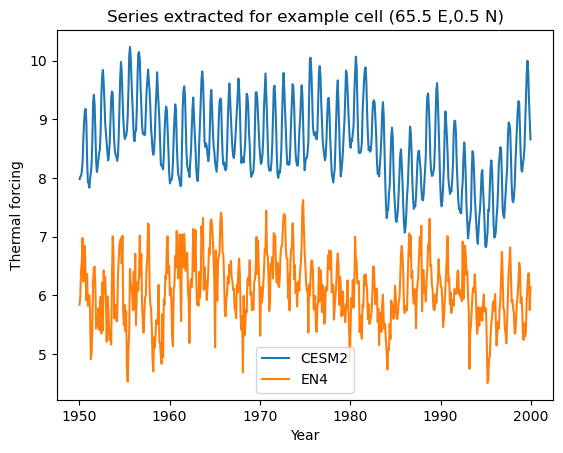

In [49]:
fig, ax = plt.subplots()
# ax.plot(test_series.time.values, test_series)
ax.plot(test_series.indexes['time'].to_datetimeindex().values, test_series, label='CESM2')
ax.plot(tobs_times,
    test_obs_trimmed, label='EN4')
ax.legend(loc='best')
ax.set(xlabel='Year', ylabel='Thermal forcing', title='Series extracted for example cell ({} E,{} N)'.format(lat_sel, lon_sel))
plt.show()

In [50]:
obs_series = test_obs_trimmed.assign_coords(new_time = ('time', tobs_times))
obs_series = obs_series.drop_indexes('time')
obs_series_1 = obs_series.set_xindex('new_time').drop_vars('time')
obs_series_1 = obs_series_1.rename({'new_time': 'time'})
obs_series_1

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_66573/786067489.py:4: UserWarning: rename 'new_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  obs_series_1 = obs_series_1.rename({'new_time': 'time'})


<xarray.DataArray 'tfdpavg0to500_bathymin100' (time: 600)> Size: 2kB
array([5.836126, 5.988926, 6.410325, ..., 6.374933, 5.747678, 6.138594],
      shape=(600,), dtype=float32)
Coordinates:
    lat      float32 4B 66.0
    lon      float32 4B 1.0
  * time     (time) datetime64[ns] 5kB 1950-01-14 1950-02-13 ... 1999-12-14

In [51]:
sim_series = test_series.assign_coords(new_time = ('time', test_series.indexes['time'].to_datetimeindex().values))
sim_series = sim_series.drop_indexes('time')
sim_series_1 = sim_series.set_xindex('new_time').drop_vars('time')
sim_series_1 = sim_series_1.rename({'new_time': 'time'})
sim_series_1 
## = sim_series_1.sel(time=slice('2000','2013')) ## maybe the underlying data has to be exactly the same length? alignment otherwise seems good...

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_66573/2873268519.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  sim_series = test_series.assign_coords(new_time = ('time', test_series.indexes['time'].to_datetimeindex().values))
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_66573/2873268519.py:4: UserWarning: rename 'new_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  sim_series_1 = sim_series_1.rename({'new_time': 'time'})


<xarray.DataArray 'TF' (time: 600)> Size: 5kB
array([7.979205, 8.02264 , 8.036263, ..., 9.337638, 8.990542, 8.656065],
      shape=(600,))
Coordinates:
    lat      float64 8B 65.5
    lon      float64 8B 0.5
  * time     (time) datetime64[ns] 5kB 1950-01-15T12:00:00 ... 1999-12-15T12:...

In [52]:
obs_ds = obs_series_1.to_dataset()
sim_ds = sim_series_1.to_dataset()

In [53]:
sim_ds = sim_ds.rename({'TF': 'tfdpavg0to500_bathymin100'})

In [54]:
qdm_result = apply_cmfunc(
    method='quantile_delta_mapping',
    obs = obs_ds.sel(time=slice('1950','1975')),
    simh = sim_ds.sel(time=slice('1950', '1975')).rename({'time':'t_simh'}),
    simp = sim_ds.sel(time=slice('1975', '2000')),
    n_quantiles = 100,
    input_core_dims={"obs": "time", "simh": "t_simh", "simp": "time"},
    # group={"obs": "time.month", "simh": "t_simh.month", "simp": "time"},
    kind = "+"
)

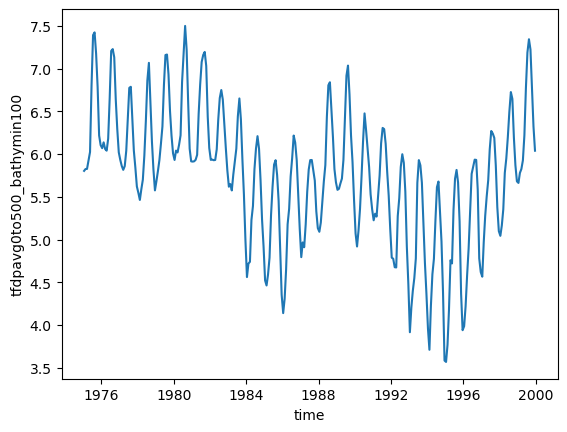

In [55]:
qdm_result.tfdpavg0to500_bathymin100.plot()

Okay, this gave us actual output, which is way farther along than we managed in our previous use of cmethods.  Let's plot against the "obs" and "sim" series:

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_66573/2304752419.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ax.plot(test_series.indexes['time'].to_datetimeindex().values, test_series, label='CESM2')


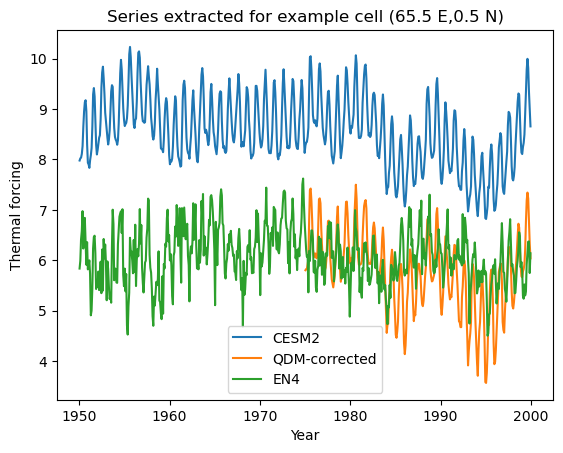

In [56]:
fig, ax = plt.subplots()
# ax.plot(test_series.time.values, test_series)
ax.plot(test_series.indexes['time'].to_datetimeindex().values, test_series, label='CESM2')
ax.plot(qdm_result.time, qdm_result.tfdpavg0to500_bathymin100.values, label='QDM-corrected')
ax.plot(tobs_times,
    test_obs_trimmed, label='EN4')
ax.legend(loc='best')
ax.set(xlabel='Year', ylabel='Thermal forcing', title='Series extracted for example cell ({} E,{} N)'.format(lat_sel, lon_sel))
plt.show()

## QDM on 3D datasets

### Process a small subset of simulated data

In [28]:
## try to do all the steps in pre-processing at once...
test_ds = ds3.TF.sel(lon=slice(lon_sel+0.1, lon_sel+1), lat=slice(lat_sel-1, lat_sel+2))
test_ds

<xarray.DataArray 'TF' (time: 600, lat: 4, lon: 1)> Size: 19kB
[2400 values with dtype=float64]
Coordinates:
  * time     (time) object 5kB 1950-01-15 12:00:00 ... 1999-12-15 12:00:00
  * lat      (lat) float64 32B 64.5 65.5 66.5 67.5
  * lon      (lon) float64 8B 1.5

In [29]:
## aligning the time indices
test_ds = test_ds.assign_coords(new_time = ('time', test_ds.indexes['time'].to_datetimeindex().values))
test_ds = test_ds.drop_indexes('time')
test_ds = test_ds.set_xindex('new_time').drop_vars('time')

## aligning the names of the variables between obs and sim
test_ds = test_ds.to_dataset()
test_ds = test_ds.rename({'new_time': 'time', 'TF': 'tfdpavg0to500_bathymin100'})
test_ds

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_23589/3224100055.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  test_ds = test_ds.assign_coords(new_time = ('time', test_ds.indexes['time'].to_datetimeindex().values))
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_23589/3224100055.py:8: UserWarning: rename 'new_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  test_ds = test_ds.rename({'new_time': 'time', 'TF': 'tfdpavg0to500_bathymin100'})


<xarray.Dataset> Size: 24kB
Dimensions:                    (lat: 4, lon: 1, time: 600)
Coordinates:
  * lat                        (lat) float64 32B 64.5 65.5 66.5 67.5
  * lon                        (lon) float64 8B 1.5
  * time                       (time) datetime64[ns] 5kB 1950-01-15T12:00:00 ...
Data variables:
    tfdpavg0to500_bathymin100  (time, lat, lon) float64 19kB ...

### Process small subset of reanalysis data

In [30]:
tobs_ds = tfEN4.sel(lon=slice(lon_sel-1, lon_sel+1), 
                    lat=slice(lat_sel-2, lat_sel+2), 
                    time=slice('1950', '2000'))
tobs_ds

<xarray.DataArray 'tfdpavg0to500_bathymin100' (time: 600, lat: 4, lon: 1)> Size: 10kB
[2400 values with dtype=float32]
Coordinates:
  * time     (time) float32 2kB 1.95e+03 1.95e+03 1.95e+03 ... 2e+03 2e+03 2e+03
  * lat      (lat) float32 16B 64.0 65.0 66.0 67.0
  * lon      (lon) float32 4B 1.0

We are back to the problem of offset grids.  Ideally we would do a point-by-point implementation that uses nearest neighbors, because xarray is good at this.  Realigning the whole grid is less efficient.  For now, let's see if it will work to just force the same grid -- this tells us whether the problem is even worth solving for cmethods implementation.

In [31]:
scam_lat = [v+0.5 for v in tobs_ds.lat.values]
scam_lon = [v+0.5 for v in tobs_ds.lon.values]

In [32]:
## overwrite them
tobs_ds = tobs_ds.assign_coords(new_lat = ('lat', scam_lat))
tobs_ds = tobs_ds.drop_indexes('lat')
tobs_ds = tobs_ds.set_xindex('new_lat').drop_vars('lat')

tobs_ds = tobs_ds.assign_coords(new_lon = ('lon', scam_lon))
tobs_ds = tobs_ds.drop_indexes('lon')
tobs_ds = tobs_ds.set_xindex('new_lon').drop_vars('lon')

tobs_ds = tobs_ds.rename({'new_lat': 'lat', 'new_lon': 'lon'})

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_23589/3190631367.py:10: UserWarning: rename 'new_lat' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  tobs_ds = tobs_ds.rename({'new_lat': 'lat', 'new_lon': 'lon'})
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_23589/3190631367.py:10: UserWarning: rename 'new_lon' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  tobs_ds = tobs_ds.rename({'new_lat': 'lat', 'new_lon': 'lon'})


In [33]:
tobs_ds

<xarray.DataArray 'tfdpavg0to500_bathymin100' (time: 600, lat: 4, lon: 1)> Size: 10kB
[2400 values with dtype=float32]
Coordinates:
  * time     (time) float32 2kB 1.95e+03 1.95e+03 1.95e+03 ... 2e+03 2e+03 2e+03
  * lat      (lat) float32 16B 64.5 65.5 66.5 67.5
  * lon      (lon) float32 4B 1.5

Reset the time index to be a datetime type.  Note that these data are also float32 rather than float64.  Could cause problems?

In [34]:
tobs_ds = tobs_ds.assign_coords(new_time = ('time', pd.to_datetime(tdec2datestr(tobs_ds.time.values))))
tobs_ds = tobs_ds.drop_indexes('time')
tobs_ds = tobs_ds.set_xindex('new_time').drop_vars('time')
tobs_ds = tobs_ds.rename({'new_time': 'time'})
tobs_ds

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_23589/2993052384.py:4: UserWarning: rename 'new_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  tobs_ds = tobs_ds.rename({'new_time': 'time'})


<xarray.DataArray 'tfdpavg0to500_bathymin100' (time: 600, lat: 4, lon: 1)> Size: 10kB
[2400 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 16B 64.5 65.5 66.5 67.5
  * lon      (lon) float32 4B 1.5
  * time     (time) datetime64[ns] 5kB 1950-01-14 1950-02-13 ... 1999-12-14

In [36]:
qdm_result_3d = apply_cmfunc(
    method = "quantile_delta_mapping",
    obs = tobs_ds.sel(time=slice('1950','1975')),
    simh = test_ds.sel(time=slice('1950', '1975')).rename({'time':'t_simh'}),
    simp = test_ds.sel(time=slice('1975', '2000')),
    n_quantiles = 100,
    input_core_dims={"obs": "time", "simh": "t_simh", "simp": "time"},
    # group={"obs": "time.month", "simh": "t_simh.month", "simp": "time"},
    kind = "+", # to calculate the relative rather than the absolute change, "*" can be used instead of "+" (this is prefered when adjusting precipitation)
)

In [38]:
test_ds

<xarray.Dataset> Size: 24kB
Dimensions:                    (lat: 4, lon: 1, time: 600)
Coordinates:
  * lat                        (lat) float64 32B 64.5 65.5 66.5 67.5
  * lon                        (lon) float64 8B 1.5
  * time                       (time) datetime64[ns] 5kB 1950-01-15T12:00:00 ...
Data variables:
    tfdpavg0to500_bathymin100  (time, lat, lon) float64 19kB ...

In [37]:
qdm_result_3d

<xarray.Dataset> Size: 12kB
Dimensions:                    (lat: 4, lon: 1, time: 300)
Coordinates:
  * lat                        (lat) float32 16B 64.5 65.5 66.5 67.5
  * lon                        (lon) float32 4B 1.5
  * time                       (time) datetime64[ns] 2kB 1975-01-15T12:00:00 ...
Data variables:
    tfdpavg0to500_bathymin100  (time, lat, lon) float64 10kB 6.473 ... 6.54

---
## Full grid application
QDM is very efficient for both of these small-scale test cases.  It looks fine.  Let's try for the full dataset?  We may now need to implement nearest-neighbor search for the offset grids.  Let's try.

In [29]:
## try to do all the steps in pre-processing at once...
test_ds_full = ds3.TF
test_ds_full

<xarray.DataArray 'TF' (time: 600, lat: 29, lon: 90)> Size: 13MB
[1566000 values with dtype=float64]
Coordinates:
  * time     (time) object 5kB 1950-01-15 12:00:00 ... 1999-12-15 12:00:00
  * lat      (lat) float64 232B 57.5 58.5 59.5 60.5 61.5 ... 82.5 83.5 84.5 85.5
  * lon      (lon) float64 720B 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5

In [30]:
## aligning the time indices
test_ds_full = test_ds_full.assign_coords(new_time = ('time', test_ds_full.indexes['time'].to_datetimeindex().values))
test_ds_full = test_ds_full.drop_indexes('time')
test_ds_full = test_ds_full.set_xindex('new_time').drop_vars('time')

## aligning the names of the variables between obs and sim
test_ds_full = test_ds_full.to_dataset()
test_ds_full = test_ds_full.rename({'new_time': 'time', 'TF': 'tfdpavg0to500_bathymin100'})
test_ds_full

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_66573/1868148141.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  test_ds_full = test_ds_full.assign_coords(new_time = ('time', test_ds_full.indexes['time'].to_datetimeindex().values))
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_66573/1868148141.py:8: UserWarning: rename 'new_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  test_ds_full = test_ds_full.rename({'new_time': 'time', 'TF': 'tfdpavg0to500_bathymin100'})


<xarray.Dataset> Size: 13MB
Dimensions:                    (lat: 29, lon: 90, time: 600)
Coordinates:
  * lat                        (lat) float64 232B 57.5 58.5 59.5 ... 84.5 85.5
  * lon                        (lon) float64 720B 0.5 1.5 2.5 ... 358.5 359.5
  * time                       (time) datetime64[ns] 5kB 1950-01-15T12:00:00 ...
Data variables:
    tfdpavg0to500_bathymin100  (time, lat, lon) float64 13MB ...

In [31]:
tobs_ds_full = tfEN4.sel( 
                    time=slice('1950', '2000'))
tobs_ds_full

<xarray.DataArray 'tfdpavg0to500_bathymin100' (time: 600, lat: 27, lon: 80)> Size: 5MB
[1296000 values with dtype=float32]
Coordinates:
  * time     (time) float32 2kB 1.95e+03 1.95e+03 1.95e+03 ... 2e+03 2e+03 2e+03
  * lat      (lat) float32 108B 59.0 60.0 61.0 62.0 63.0 ... 82.0 83.0 84.0 85.0
  * lon      (lon) float32 320B 1.0 282.0 283.0 284.0 ... 358.0 359.0 360.0

In the small-scale application, we overwrote the lat/lon to force the example onto the same points.  Obviously we don't want to do that in the real deployment version.  Let's see if our QDM implementation can deal with offset grid (probably not) or reproject where needed.

Reset the time index to be a datetime type.  Note that these data are also float32 rather than float64.  Could cause problems?

In [32]:
tobs_ds_full = tobs_ds_full.assign_coords(new_time = ('time', pd.to_datetime(tdec2datestr(tobs_ds_full.time.values))))
tobs_ds_full = tobs_ds_full.drop_indexes('time')
tobs_ds_full = tobs_ds_full.set_xindex('new_time').drop_vars('time')
tobs_ds_full = tobs_ds_full.rename({'new_time': 'time'})
tobs_ds_full

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_66573/132400684.py:4: UserWarning: rename 'new_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  tobs_ds_full = tobs_ds_full.rename({'new_time': 'time'})


<xarray.DataArray 'tfdpavg0to500_bathymin100' (time: 600, lat: 27, lon: 80)> Size: 5MB
[1296000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 108B 59.0 60.0 61.0 62.0 63.0 ... 82.0 83.0 84.0 85.0
  * lon      (lon) float32 320B 1.0 282.0 283.0 284.0 ... 358.0 359.0 360.0
  * time     (time) datetime64[ns] 5kB 1950-01-14 1950-02-13 ... 1999-12-14

In [33]:
qdm_result_3d_full = apply_cmfunc(
    method = "quantile_delta_mapping",
    obs = tobs_ds_full.sel(time=slice('1950','1975')),
    simh = test_ds_full.sel(time=slice('1950', '1975')).rename({'time':'t_simh'}),
    simp = test_ds_full.sel(time=slice('1975', '2000')),
    n_quantiles = 100,
    input_core_dims={"obs": "time", "simh": "t_simh", "simp": "time"},
    # group={"obs": "time.month", "simh": "t_simh.month", "simp": "time"},
    kind = "+", # to calculate the relative rather than the absolute change, "*" can be used instead of "+" (this is prefered when adjusting precipitation)
)

ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'lat' ('lat',)

### Reproject obs to match CESM grid
Okay, as expected we cannot do this with mismatched grids.  Warp the grid to match using `rioxarray`?

In [34]:
import rioxarray
from pyproj import CRS

In [35]:
cc = CRS("EPSG:4326")

tobs_ds_full.rio.write_crs(cc, inplace=True).rio.set_spatial_dims(
    x_dim="lon",
    y_dim="lat",
    inplace=True,
).rio.write_coordinate_system(inplace=True)

<xarray.DataArray 'tfdpavg0to500_bathymin100' (time: 600, lat: 27, lon: 80)> Size: 5MB
[1296000 values with dtype=float32]
Coordinates:
  * lat          (lat) float32 108B 59.0 60.0 61.0 62.0 ... 82.0 83.0 84.0 85.0
  * lon          (lon) float32 320B 1.0 282.0 283.0 284.0 ... 358.0 359.0 360.0
  * time         (time) datetime64[ns] 5kB 1950-01-14 1950-02-13 ... 1999-12-14
    spatial_ref  int64 8B 0

In [36]:
test_ds_full.rio.write_crs(cc, inplace=True).rio.set_spatial_dims(
    x_dim="lon",
    y_dim="lat",
    inplace=True,
).rio.write_coordinate_system(inplace=True)

<xarray.Dataset> Size: 13MB
Dimensions:                    (lat: 29, lon: 90, time: 600)
Coordinates:
  * lat                        (lat) float64 232B 57.5 58.5 59.5 ... 84.5 85.5
  * lon                        (lon) float64 720B 0.5 1.5 2.5 ... 358.5 359.5
  * time                       (time) datetime64[ns] 5kB 1950-01-15T12:00:00 ...
    spatial_ref                int64 8B 0
Data variables:
    tfdpavg0to500_bathymin100  (time, lat, lon) float64 13MB ...

In [37]:
tobs_repr_match = tobs_ds_full.rio.reproject_match(test_ds_full)

In [38]:
## rename the coords 
tobs_repr_match = tobs_repr_match.rename({'x': 'lon', 'y': 'lat'})
tobs_repr_match

<xarray.DataArray 'tfdpavg0to500_bathymin100' (time: 600, lat: 29, lon: 90)> Size: 6MB
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [9.70400429e+00, 1.09999999e+20, 1.09999999e+20, ...,
         1.02952576e+01, 1.01108723e+01, 9.76764393e+00],
        [9.86950588e+00, 2.69916511e+00, 1.09999999e+20, ...,
         1.02072163e+01, 1.01913681e+01, 1.00020990e+01],
        ...,
        [2.03849125e+00, 1.19509780e+00, 1.20272052e+00, ...,
         1.93476188e+00, 1.96503520e+00, 2.00024128e+00],
        [1.78069413e+00, 1.21679735e+00, 1.22232509e+00, ...,
         1.71250784e+00, 1.73207343e+00, 1.75540328e+00],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [9.16204548e+00, 1.09999999e+20, 1.09999999e+20, ...,
         9.63706779e+00, 9.53308296e+00, 9.31538677e+00],
        [9.38930225e+00, 2.62292099e+00, 1.09999999e+20, ...,
         9.68313026e+00, 9.66195583e+00, 9.48563385e+00],
...
         2.37804127e+00, 2.42110753e+00, 2.46811461e+00],
        [2.13311648e+00, 1.05958474e+00, 1.06736207e+00, ...,
         2.03579855e+00, 2.06570864e+00, 2.09882283e+00],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [1.08194571e+01, 1.09999999e+20, 1.09999999e+20, ...,
         1.15201950e+01, 1.12038851e+01, 1.07139864e+01],
        [1.09731598e+01, 2.20546317e+00, 1.09999999e+20, ...,
         1.12222815e+01, 1.13268566e+01, 1.11960793e+01],
        ...,
        [2.31204438e+00, 1.02852964e+00, 1.03864527e+00, ...,
         2.17923951e+00, 2.22007632e+00, 2.26490688e+00],
        [1.96943748e+00, 1.06912100e+00, 1.07619619e+00, ...,
         1.87830675e+00, 1.90607071e+00, 1.93708551e+00],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]],
      shape=(600, 29, 90), dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 5kB 1950-01-14 1950-02-13 ... 1999-12-14
    spatial_ref  int64 8B 0
  * lon          (lon) float64 720B 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat          (lat) float64 232B 57.5 58.5 59.5 60.5 ... 82.5 83.5 84.5 85.5
Attributes:
    _FillValue:  nan

In [40]:
from dask.diagnostics import ProgressBar

with ProgressBar():

    qdm_result_3d_full = apply_cmfunc(
        method = "quantile_delta_mapping",
        obs = tobs_repr_match.sel(time=slice('1950','1975')),
        simh = test_ds_full.sel(time=slice('1950', '1975')).rename({'time':'t_simh'}),
        simp = test_ds_full.sel(time=slice('1975', '2000')),
        n_quantiles = 100,
        input_core_dims={"obs": "time", "simh": "t_simh", "simp": "time"},
        # group={"obs": "time.month", "simh": "t_simh.month", "simp": "time"},
        kind = "+", # to calculate the relative rather than the absolute change, "*" can be used instead of "+" (this is prefered when adjusting precipitation)
    )

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_66573/14849400.py:29: RuntimeWarning: All-NaN slice encountered
  global_max = kwargs.get("global_max", max(np.nanmax(obs), np.nanmax(simh)))
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_66573/14849400.py:30: RuntimeWarning: All-NaN slice encountered
  global_min = kwargs.get("global_min", min(np.nanmin(obs), np.nanmin(simh)))
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_66573/1020608500.py:145: RuntimeWarning: invalid value encountered in divide
  return cdf / cdf[-1]


In [41]:
qdm_result_3d_full

<xarray.Dataset> Size: 6MB
Dimensions:                    (lat: 29, lon: 90, time: 300)
Coordinates:
    spatial_ref                int64 8B 0
  * lon                        (lon) float64 720B 0.5 1.5 2.5 ... 358.5 359.5
  * lat                        (lat) float64 232B 57.5 58.5 59.5 ... 84.5 85.5
  * time                       (time) datetime64[ns] 2kB 1975-01-15T12:00:00 ...
Data variables:
    tfdpavg0to500_bathymin100  (time, lat, lon) float64 6MB 10.52 ... 1.423

Success!  Let's check the output to see if it's sensible.

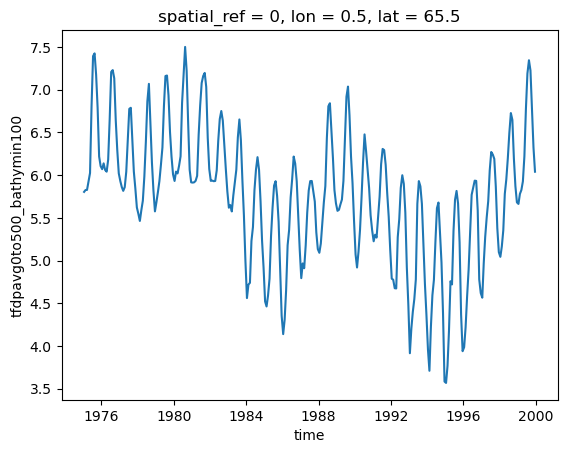

In [57]:
example_cell_series = qdm_result_3d_full.tfdpavg0to500_bathymin100.sel(lat=lat_sel, lon=lon_sel, method='nearest')
example_cell_series.plot()

And compare against the same example cell computed with 1d QDM:

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_66573/132273399.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ax.plot(test_series.indexes['time'].to_datetimeindex().values, test_series, label='CESM2')


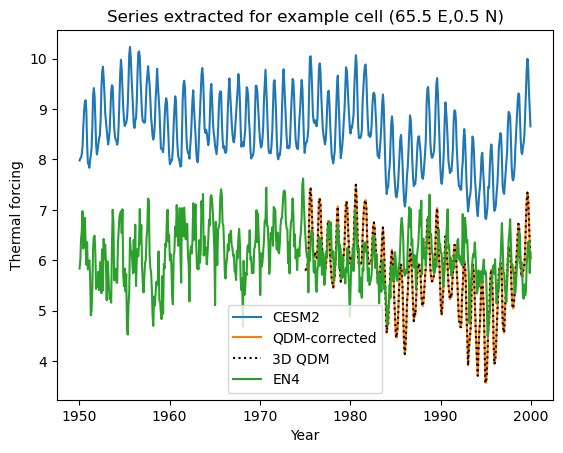

In [59]:
fig, ax = plt.subplots()
# ax.plot(test_series.time.values, test_series)
ax.plot(test_series.indexes['time'].to_datetimeindex().values, test_series, label='CESM2')
ax.plot(qdm_result.time, qdm_result.tfdpavg0to500_bathymin100.values, label='QDM-corrected')
ax.plot(example_cell_series.time, example_cell_series.values, 
        color='k', ls=':', label='3D QDM')
ax.plot(tobs_times,
    test_obs_trimmed, label='EN4')
ax.legend(loc='best')
ax.set(xlabel='Year', ylabel='Thermal forcing', title='Series extracted for example cell ({} E,{} N)'.format(lat_sel, lon_sel))
plt.show()

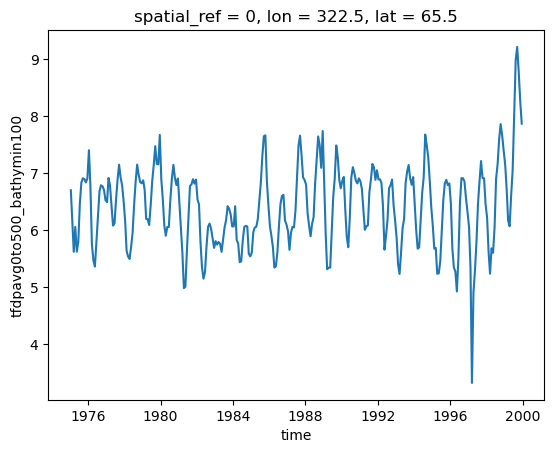

In [63]:
## vicinity of Helheim glacier
lat_hel = 65.5
lon_hel = 322

example_cell_hel = qdm_result_3d_full.tfdpavg0to500_bathymin100.sel(lat=lat_hel, lon=lon_hel, method='nearest')
example_cell_hel.plot()

[(250.0, 360.0)]

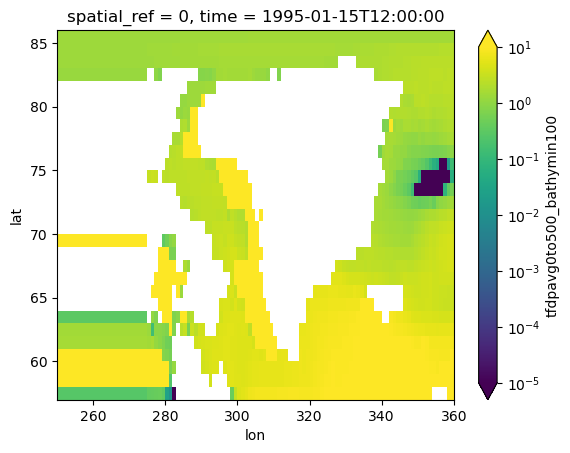

In [75]:
from matplotlib import colors
fig, ax = plt.subplots()
qdm_result_3d_full.tfdpavg0to500_bathymin100.sel(time='1995-01-01', method='nearest').plot(
    ax=ax,
    norm=colors.SymLogNorm(linthresh=1e-5),
    vmin=1e-5, vmax=1e1,
)
ax.set(xlim=(250, 360))

Do we need to split the time?

Check whether we can modify the full simulated set over the full period, 1950-2000.

In [76]:
qdm_result_3d_fullperiod = apply_cmfunc(
    method = "quantile_delta_mapping",
    obs = tobs_repr_match.sel(time=slice('1950','2000')),
    simh = test_ds_full.sel(time=slice('1950', '2000')).rename({'time':'t_simh'}),
    simp = test_ds_full.sel(time=slice('1950', '2000')),
    n_quantiles = 100,
    input_core_dims={"obs": "time", "simh": "t_simh", "simp": "time"},
    # group={"obs": "time.month", "simh": "t_simh.month", "simp": "time"},
    kind = "+", # to calculate the relative rather than the absolute change, "*" can be used instead of "+" (this is prefered when adjusting precipitation)
)

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_66573/14849400.py:29: RuntimeWarning: All-NaN slice encountered
  global_max = kwargs.get("global_max", max(np.nanmax(obs), np.nanmax(simh)))
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_66573/14849400.py:30: RuntimeWarning: All-NaN slice encountered
  global_min = kwargs.get("global_min", min(np.nanmin(obs), np.nanmin(simh)))
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_66573/1020608500.py:145: RuntimeWarning: invalid value encountered in divide
  return cdf / cdf[-1]


In [77]:
qdm_result_3d_fullperiod

<xarray.Dataset> Size: 13MB
Dimensions:                    (lat: 29, lon: 90, time: 600)
Coordinates:
    spatial_ref                int64 8B 0
  * lon                        (lon) float64 720B 0.5 1.5 2.5 ... 358.5 359.5
  * lat                        (lat) float64 232B 57.5 58.5 59.5 ... 84.5 85.5
  * time                       (time) datetime64[ns] 5kB 1950-01-15T12:00:00 ...
Data variables:
    tfdpavg0to500_bathymin100  (time, lat, lon) float64 13MB 9.795 ... 1.423

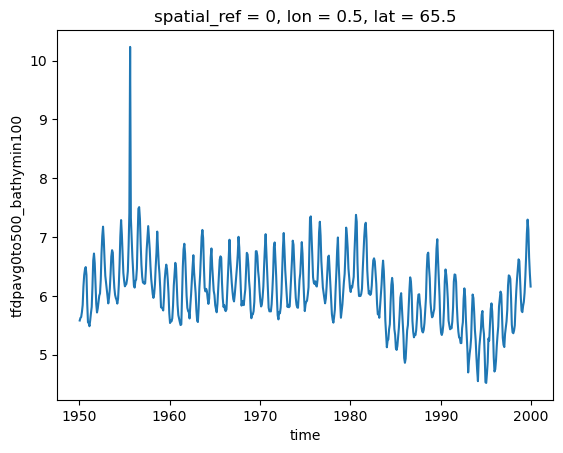

In [78]:
example_cell_series = qdm_result_3d_fullperiod.tfdpavg0to500_bathymin100.sel(lat=lat_sel, lon=lon_sel, method='nearest')
example_cell_series.plot()

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_66573/1986661789.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ax.plot(test_series.indexes['time'].to_datetimeindex().values, test_series, label='CESM2')


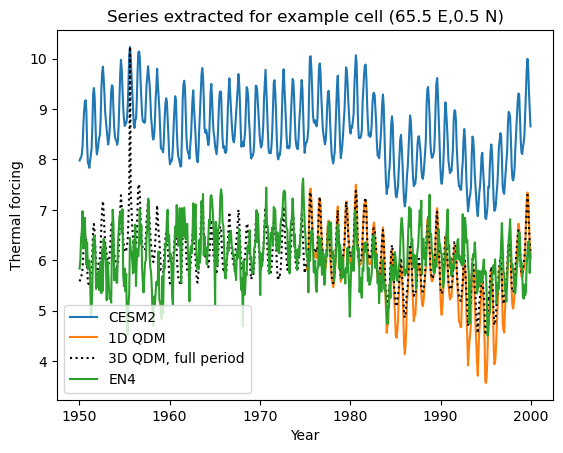

In [81]:
fig, ax = plt.subplots()
# ax.plot(test_series.time.values, test_series)
ax.plot(test_series.indexes['time'].to_datetimeindex().values, test_series, label='CESM2')
ax.plot(qdm_result.time, qdm_result.tfdpavg0to500_bathymin100.values, label='1D QDM')
ax.plot(example_cell_series.time, example_cell_series.values, 
        color='k', ls=':', label='3D QDM, full period')
ax.plot(tobs_times,
    test_obs_trimmed, label='EN4')
ax.legend(loc='best')
ax.set(xlabel='Year', ylabel='Thermal forcing', title='Series extracted for example cell ({} E,{} N)'.format(lat_sel, lon_sel))
plt.show()